In [20]:
# Author: Nathan Jansen, jansenn1@msu.edu
#
# Description: A Qiskit program to run entangled cat states using IBM's publicly accessible quantum compters
#              and calculate the Shannon Entropy of the resulting runs. After runs calculate the entropies, 
#              plot data & linear fit.
#
# Revision History: Initial version, 06/30/2021
#                   Added calulations and plotting, 11/16/2021
#
# Notes:  Must have an IBMQ account, Qiskit's youtube has tutorials on setting one up
#---------------------------------------------------------------------------------------------------------

from qiskit import *
import numpy as np
from qiskit.visualization import plot_circuit_layout
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.ticker as ticker
IBMQ.load_account()


/Users/nathanjansen/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-11-16 15:05:13,492: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

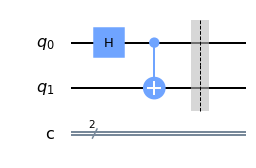

In [21]:
# Setting up the circuits

n = 2  # number of qubits
cat_circs = [];
for i in range(4):
    cat = QuantumCircuit(n, n);
    # Apply H gates
    
    cat.h(0);
    
    # Adding CNOT
    
    cat.cx(range(n-1),range(1,n));

    # Add barriers before measurements

    cat.barrier();
    cat_circs.append(cat);
    n = n + 1
    
cat_circs[0].draw(output='mpl')

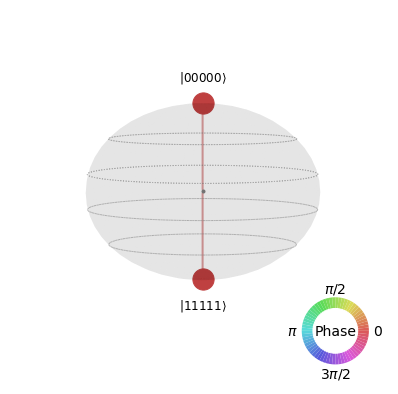

In [22]:
# This part checks if Qiskit is interpreting the cat state correctly by plotting the Bloch Sphere

from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

backend = BasicAer.get_backend('statevector_simulator')      # statevector simulator is the backend
result = execute(cat, backend).result()                   # Run the circuit on the backend
psi  = result.get_statevector(cat)                        # Declare results as Psi


# Plotting the Bloch sphere
plot_state_qsphere(psi)

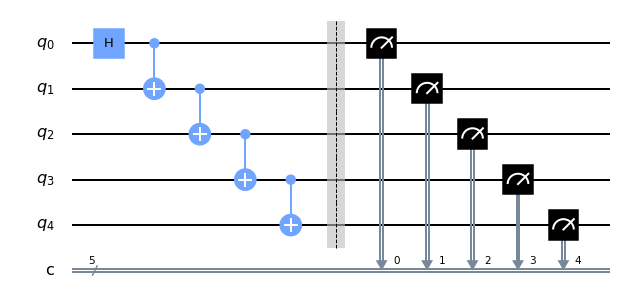

In [23]:
#Adding measurements, you must add measurements after Bloch Sphere

n = 2
for cat in cat_circs:
    cat.measure(range(n), range(n));
    n = n+1

cat.draw(output='mpl')

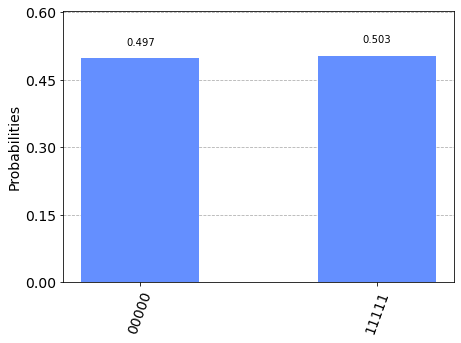

In [24]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(cat, backend = simulator, shots = 8192).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [25]:
# Making the list of circuits

qc_list=[];

for cat in cat_circs:
    dummylist = []
    for i in range(0,75):
        dummylist.append(cat);
    qc_list.append(dummylist);


In [26]:
# Run the job on quantum computer

provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_bogota')  

job1 = execute(qc_list[0], backend=backend, shots = 8192)
job2 = execute(qc_list[1], backend=backend, shots = 8192)
job3 = execute(qc_list[2], backend=backend, shots = 8192)
job4 = execute(qc_list[3], backend=backend, shots = 8192)

In [27]:
#Monitoring the job, queue status/postion, and when completed
from qiskit.tools.monitor import job_monitor

job_monitor(job1)
job_monitor(job2)
job_monitor(job3)
job_monitor(job4)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [28]:
def entropy(p,s): # Defining the function that calculates the Entropy
    if p == 0:
        a = 0
    else:
        a = -p/s*np.log2(p/s)
    return float(a)

In [29]:
results = [job1.result(),job2.result(),job3.result(),job4.result()]

In [30]:
# Grab job counts and places them in an array in binary order

cnts = [] # list to hold the set of counts for each job

qn = 2

for result in results:
    nqbit = qn   
    n = 2**nqbit        
    vec = np.zeros(n)   #array for counts
    
    data =[]
    
    count = result.get_counts()
    for i in count:
        for key,value in i.items():
            idx = 0
            for i,b in enumerate(reversed(key)):
                if b == '1':
                    idx += 2**i
            vec[idx] = value  
        data.append(vec)
        vec = np.zeros(n)
    cnts.append(data)  
    qn = qn + 1 


In [31]:
ent = []                           # List of averaged entropy
stdev = []                         # Standard deviation between runs
w = []
for job in cnts:
    circ = []                             # This will hold the entropies of each circuit/job
    for run in job:
        h=[]                          # This will hold the result of individual counts
        for count in run:
            h.append(entropy(count,8192))
        circ.append(np.sum(h))
    stdev.append(np.std(circ))
    ent.append(np.average(circ))
    w.append(1/(np.std(circ))**2)  # Weights for the fits

In [32]:
print(ent)
print(stdev)
print(w)

[1.3806308203294608, 1.8705002885189523, 2.227375014004702, 2.6166127775442676]
[0.00984504271130751, 0.01396463214095627, 0.021128968324087474, 0.022712907761019332]
[10317.269875093605, 5127.917154049037, 2239.976261927155, 1938.4496528118013]


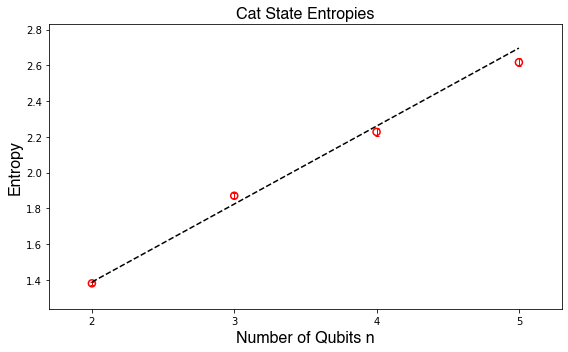

[0.43613102 0.51552663]


In [33]:
#----------------------------------------------------------------------------
#       Plotting the Data
#----------------------------------------------------------------------------

fig, axs = plt.subplots(1,2,figsize=(8,5))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  #this sets the axis tick marks
ax.margins(x = 0.1, y=0.1)

x = [2,3,4,5]
y = ent 

coef = np.polyfit(x,y,1, w = w )
poly1d_fn = np.poly1d(coef) 

plt.plot(x, poly1d_fn(x), '--k') 


plt.scatter(x, ent,s=50, marker = 'o', facecolors='none', edgecolors='r',linewidth=1.5)
plt.errorbar(x, ent,yerr = stdev,fmt=' ', 
                 ecolor='r',elinewidth=1,capsize=2, zorder=0)

    
plt.title('Cat State Entropies', fontsize=16, fontweight='bold', fontname = 'Helvetica')
plt.xlabel('Number of Qubits n', fontsize=16, fontname = 'Helvetica')
plt.ylabel('Entropy', fontsize=16, fontname = 'Helvetica')
plt.tight_layout() 

plt.show()


print(coef)  # slope and intercept
